<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение
### Семинар 4. Метрические методы

<br />
<br />
23 сентября 2021

### Импортируем библиотеки


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split

np.random.seed(42)

### Привычный датасет

In [2]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = X[:, 2:4]
features = np.array(["длина лепестка", "ширина лепестка"])
labels = np.array(["щетинистый", "виргинский", "разноцветный"])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=30, 
                                                    random_state=10)

In [21]:
X_train.shape, X_test.shape

((120, 2), (30, 2))

In [3]:
def show_legend():
    cb = plt.colorbar()
    loc = [0, 1, 2]
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)

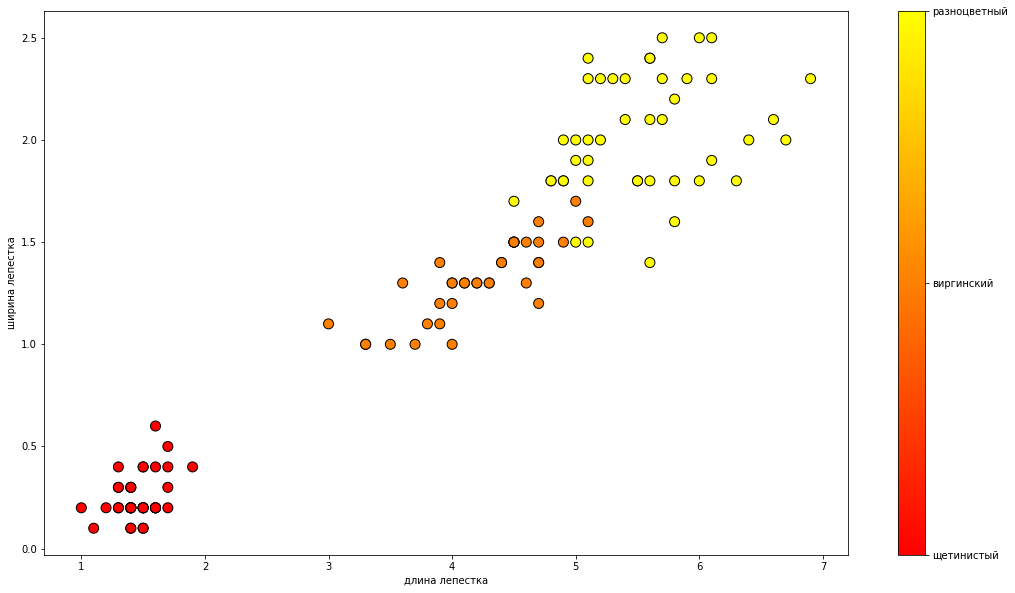

In [4]:
plt.figure(figsize=(18.0, 10.0))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap='autumn', edgecolors="black")
plt.xlabel(features[0])
plt.ylabel(features[1])
show_legend()

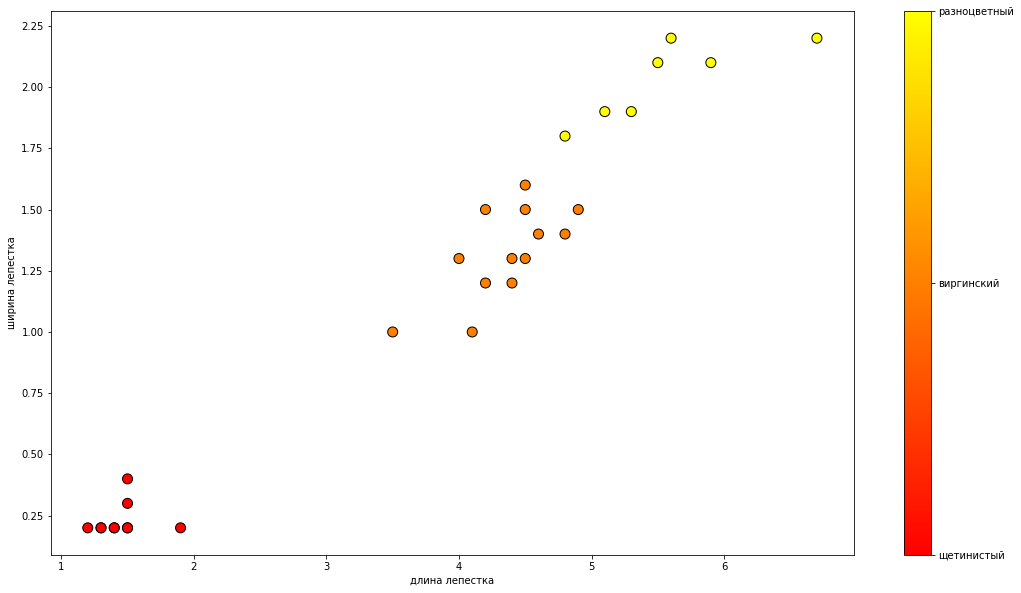

In [5]:
plt.figure(figsize=(18.0, 10.0))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=100, cmap='autumn', edgecolors="black")
plt.xlabel(features[0])
plt.ylabel(features[1])
show_legend()

### Метод ближайшего соседа

In [6]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
_ = model.fit(X_train, y_train)


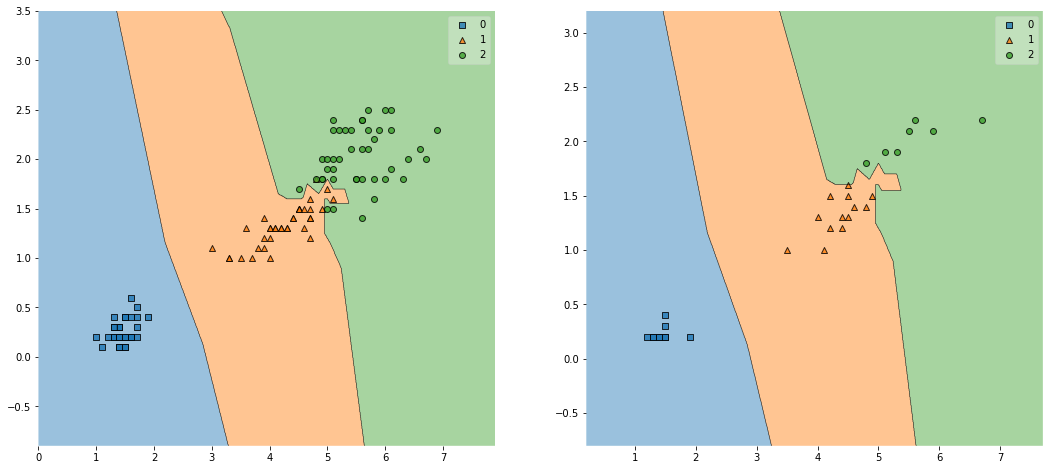

In [7]:
from matplotlib.gridspec import GridSpec

fig, gs = plt.figure(figsize=(18, 8)), GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, y_train, model, ax=ax[0])
plot_decision_regions(X_test, y_test, model, ax=ax[1])

plt.show()

### kNN

In [8]:
models = []
for n_neighbors in range(1, 121):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    models.append(model)

<div class="alert alert-info">
<b>Вопрос 1:</b> Какое $k$ выбрать?
</div>

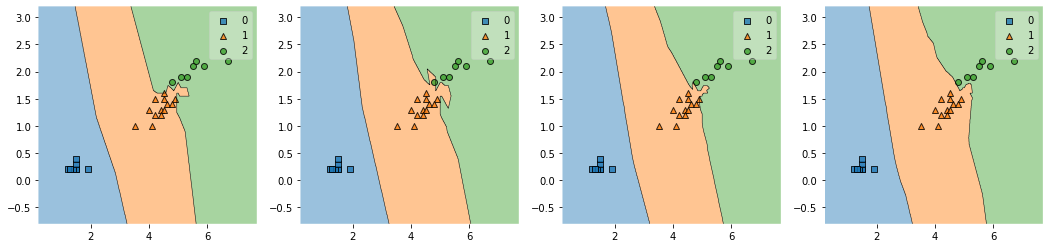

In [9]:
fig, gs = plt.figure(figsize=(18,4)), GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, y_test, models[i], ax=ax[i])

plt.show()

C:\Users\avalur\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


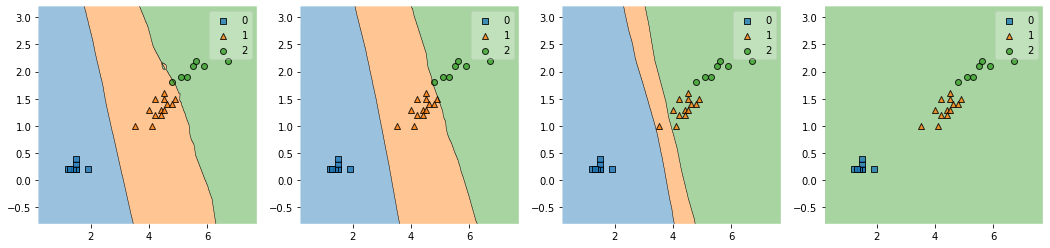

In [10]:
fig, gs = plt.figure(figsize=(18,4)), GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, y_test, models[30*i + 28], ax=ax[i])

plt.show()

### Линейно убывающие веса

In [11]:
def lin_weights(distance):
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

<div class="alert alert-info">
<b>Вопрос 2:</b> Что изменится при линейном убывании весов? Какое $k$ разумно выбрать теперь?
</div>

In [15]:
models = []
for n_neighbors in range(1, 121):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                 weights=lin_weights)
    model.fit(X_train, y_train)
    models.append(model)

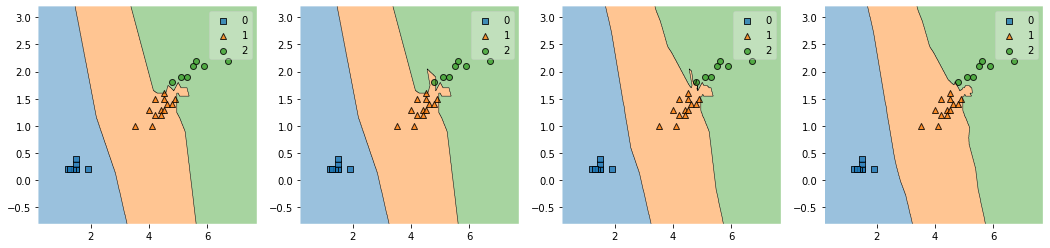

In [16]:
fig, gs = plt.figure(figsize=(18,4)), GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, y_test, models[i], ax=ax[i])

plt.show()

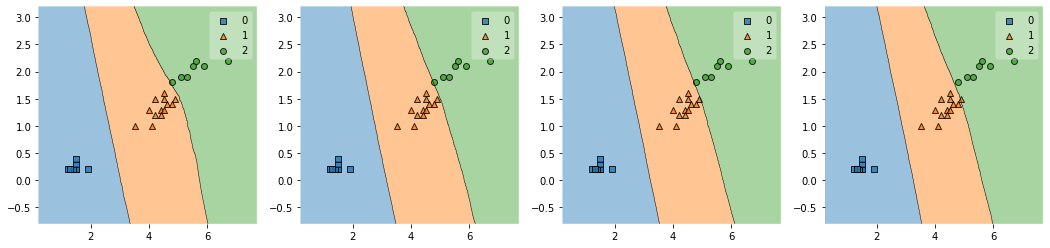

In [17]:
fig, gs = plt.figure(figsize=(18,4)), GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i in range(4):
    plot_decision_regions(X_test, y_test, models[30 * i + 28], ax=ax[i])

plt.show()

### Метод окна Парзена

In [18]:
def K(distance, h=0.05):
    ret = np.array(distance) / h
    return (1 - ret**2) * (np.abs(ret) <= 1)

<div class="alert alert-info">
<b>Вопрос 3:</b> Какое значение разумно выбрать для $h$?
</div>

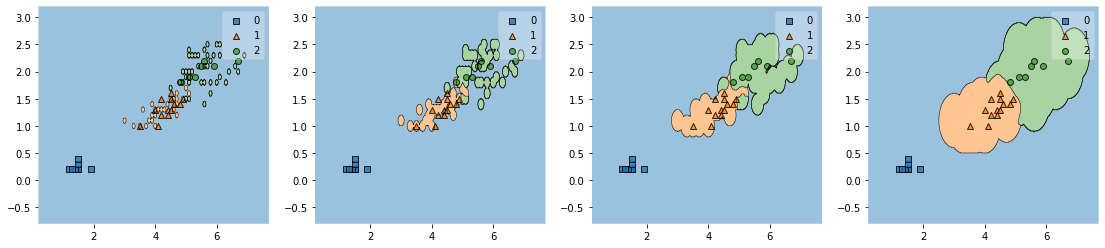

In [19]:
fig, gs = plt.figure(figsize=(19,4)), GridSpec(1, 4)

ax = []
for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, y_test, model, ax=ax[i])

plt.show()

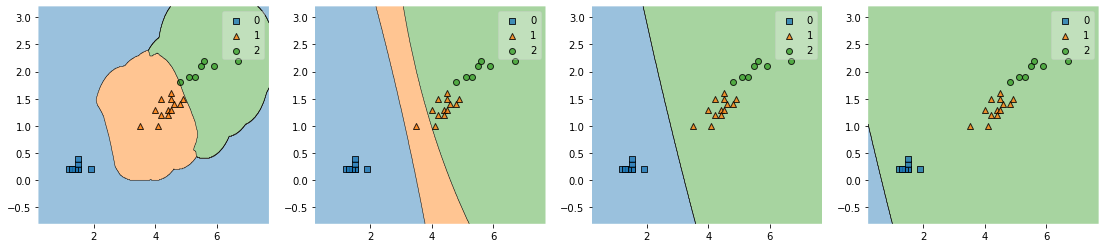

In [20]:
fig, gs = plt.figure(figsize=(19,4)), GridSpec(1, 4)

ax = []
for i, h in enumerate([1.0, 5.0, 10.0, 20.0]):
    model = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h))
    model.fit(X_train, y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, y_test, model, ax=ax[i])

plt.show()

### Метод потенциалов

In [22]:
y_new_train = y_train.copy()
y_new_train[y_new_train == 2] = 0

y_new_test = y_test.copy()
y_new_test[y_new_test == 2] = 0

#### Реализуем метод потенциалов

In [26]:
from scipy.spatial.distance import cdist

# Potential Functions Method
class PFM(object):
    def __init__(self, kernel=None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
    
    def scores(self, X):
        features = self.gams * self.kernel(cdist(X, self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y == 0)].T, axis=-1),
             np.sum(features.T[np.where(self.Y == 1)].T, axis=-1)]).T
        return scores
    
    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)
    
    def fit(self, X, Y, epoch=5):
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y) # what if np.ones_like(Y)?
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                # скрытый вопрос на понимание кода — почему так?
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

<div class="alert alert-info">
<b>Вопрос 4:</b> Если веса и радиусы действия равны, можно ли выразить метод потенциалов через окно Парзена?
</div>

In [27]:
# def K(distance, h=0.05):
#     ret = np.array(distance)/h
#     return (1 - ret**2) * (np.abs(ret) <= 1)

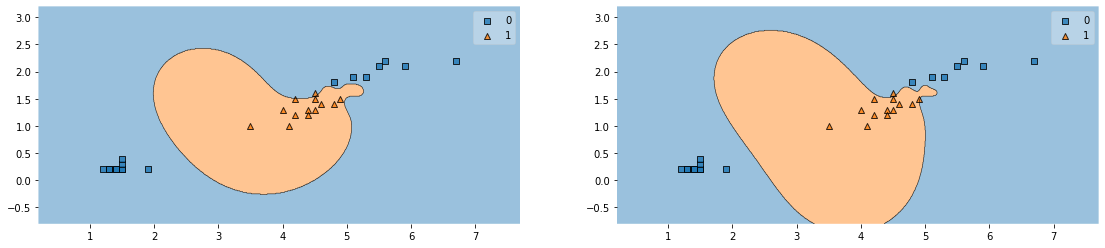

In [28]:
epochs = [1, 5]
fig, gs = plt.figure(figsize=(19,4)), GridSpec(1, len(epochs))

ax = []
for i, epoch in enumerate(epochs):
    model = PFM(kernel=lambda r: 1 / (r + 1e-5))
    model.fit(X_train, y_new_train, epoch)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test, y_new_test, model, ax=ax[i])

plt.show()

### Формула Надарая-Ватсона

In [29]:
l = 150

# Генерация данных
x = np.linspace(0, 30, num=l)
Y_without_noise = x + 4 * np.sin(x)
Y = Y_without_noise + 4 * np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

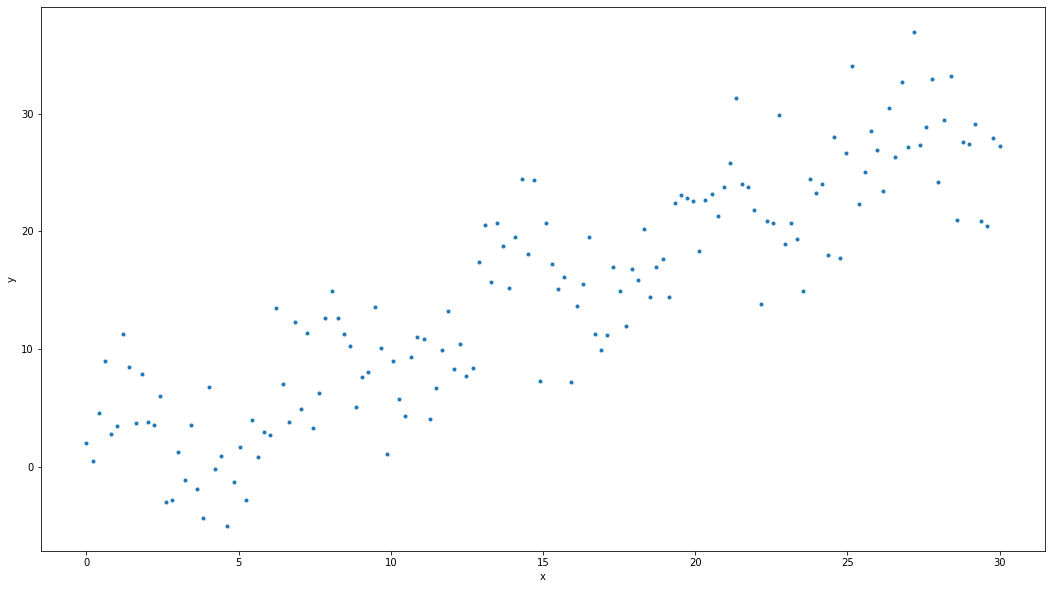

In [30]:
fig, ax = plt.subplots()

fig.set_size_inches(18.0, 10.0)

plt.plot(x, Y, '.')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [31]:
class FNW(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel
            
    def predict(self, X):
        features = np.sum(self.Y * self.kernel(cdist(X, self.X)), axis=-1)
        return features / (np.sum(self.kernel(cdist(X, self.X)), axis=-1) + 1e-5)
    
    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

In [32]:
def K(distance, h=2):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [33]:
model = FNW(kernel=lambda x: K(x, h=1))
model.fit(X, Y)

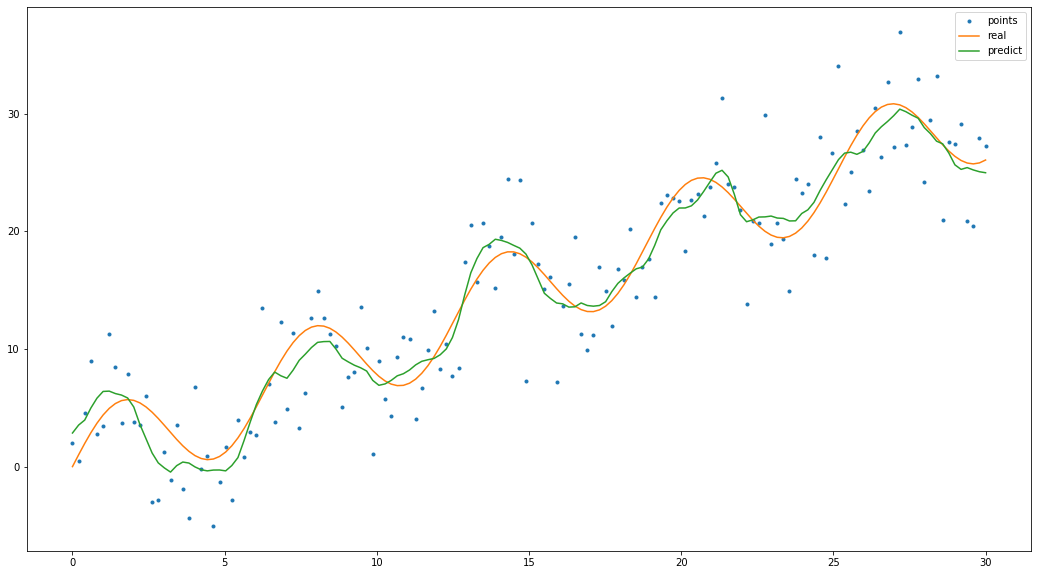

In [34]:
plt.figure(figsize=(18.0, 10.0))
plt.plot(x, Y, '.', label='points')
plt.plot(x, Y_without_noise, label='real')
plt.plot(x, model.predict(X), label='predict')

plt.legend(loc='best')
plt.show()

<div class="alert alert-info">
<b>Вопрос 5:</b> Предложите, как сделать апроксимацию более точной? Более гладкой? Как вы думаете, улучшится или ухудшится обощающая способность регрессии при данных изменениях?
</div>